In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [96]:
data = pd.read_csv('train.csv')
X = data.drop('exam_score', axis=1)
y = data['exam_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
X_train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
625149,625149,20,other,b.com,0.84,79.0,yes,9.9,good,mixed,low,hard
276435,276435,19,female,b.com,3.35,94.2,yes,6.0,good,group study,medium,moderate
43949,43949,18,female,ba,2.20,87.5,yes,6.8,good,online videos,high,easy
280523,280523,18,male,bca,3.10,64.0,yes,7.6,average,self-study,medium,moderate
619977,619977,22,female,diploma,1.44,56.2,yes,5.5,average,online videos,medium,hard


смотрим на имеющиеся признаки. надо проверить, все ли нам нужны. для начала разделим на категориальные и числовые

In [98]:
data.dtypes

,0
id,int64
age,int64
gender,object
course,object
study_hours,float64
class_attendance,float64
internet_access,object
sleep_hours,float64
sleep_quality,object
study_method,object


In [99]:
cat_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
num_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']

In [100]:
data.isna().sum()
#пропусков нет, это победа

,0
id,0
age,0
gender,0
course,0
study_hours,0
class_attendance,0
internet_access,0
sleep_hours,0
sleep_quality,0
study_method,0


проверяем, насколько числовые данные зависят друг от друга.
они, к счастью, почти не зависят

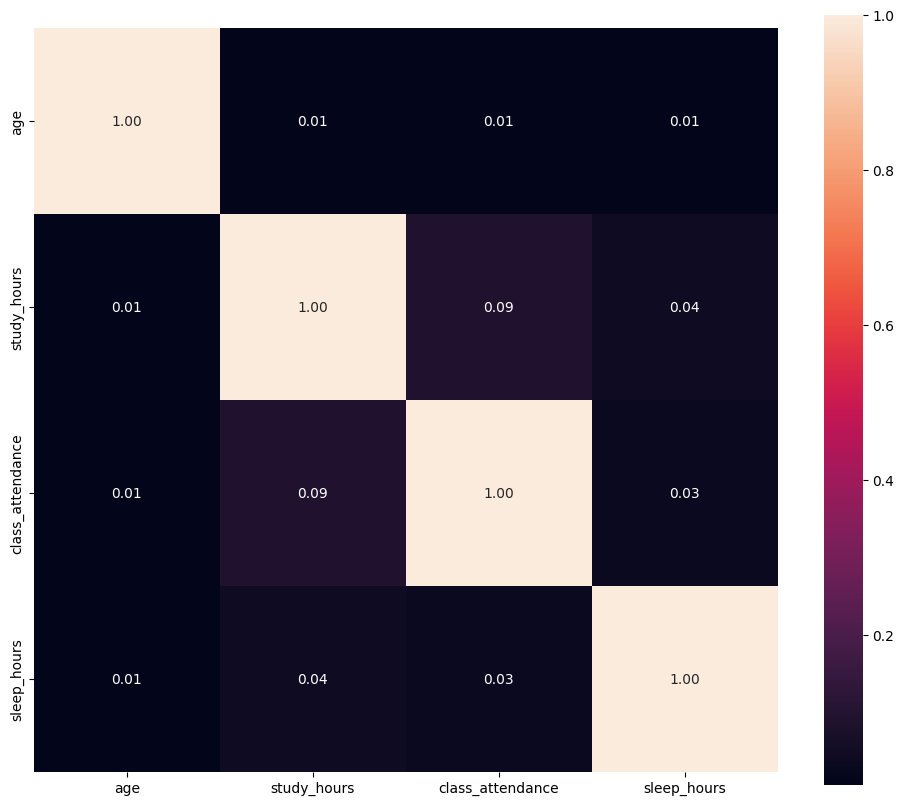

In [101]:
df = X_train[num_cols]

plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(),fmt='.2f', square = True, annot=True)
plt.show()

смотрим, насколько равномерно распределены данные.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'study_hours'}>],
       [<Axes: title={'center': 'class_attendance'}>,
        <Axes: title={'center': 'sleep_hours'}>]], dtype=object)

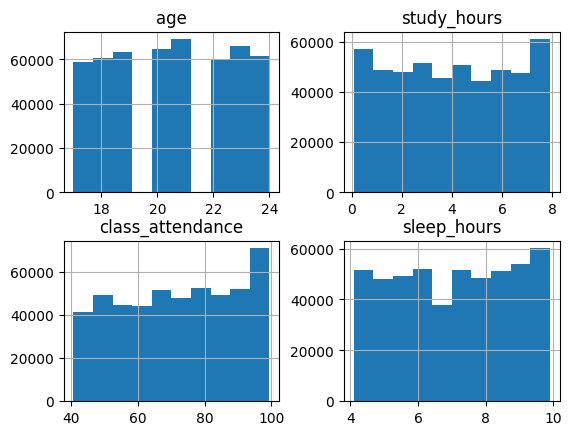

In [102]:
X_train[num_cols].hist()

In [103]:
X_train[cat_cols].nunique()

,0
gender,3
course,7
internet_access,2
sleep_quality,3
study_method,5
facility_rating,3
exam_difficulty,3


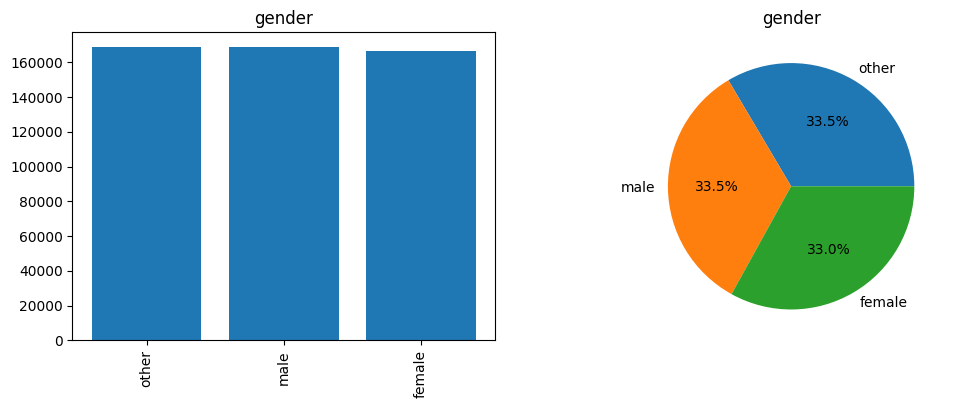

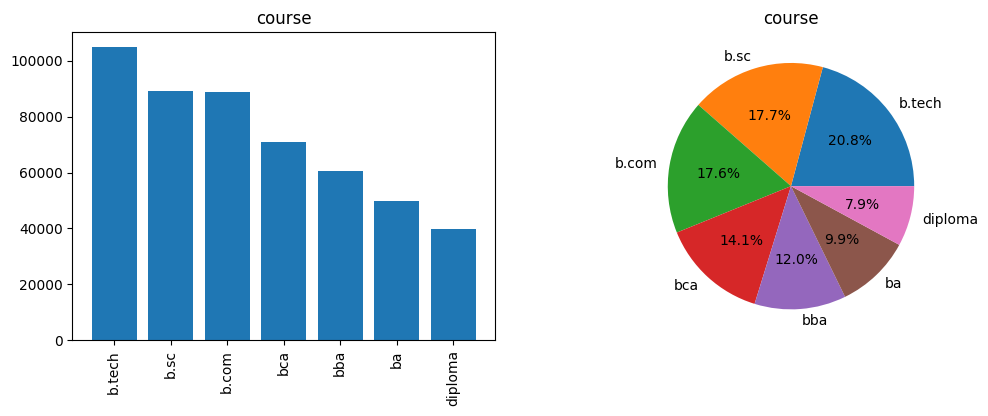

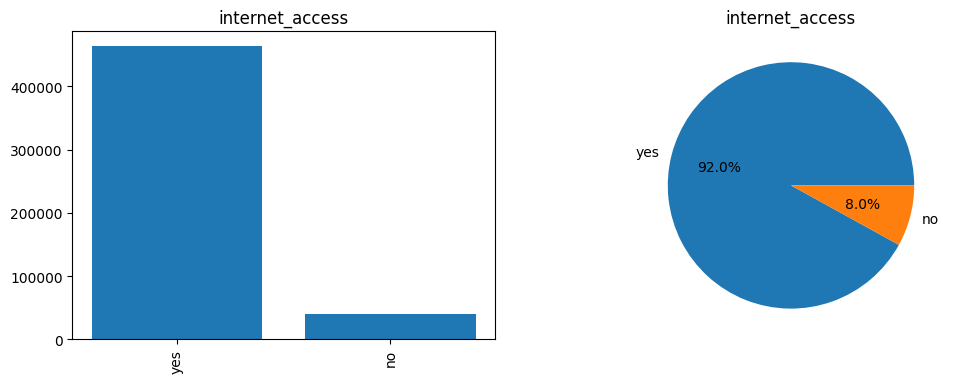

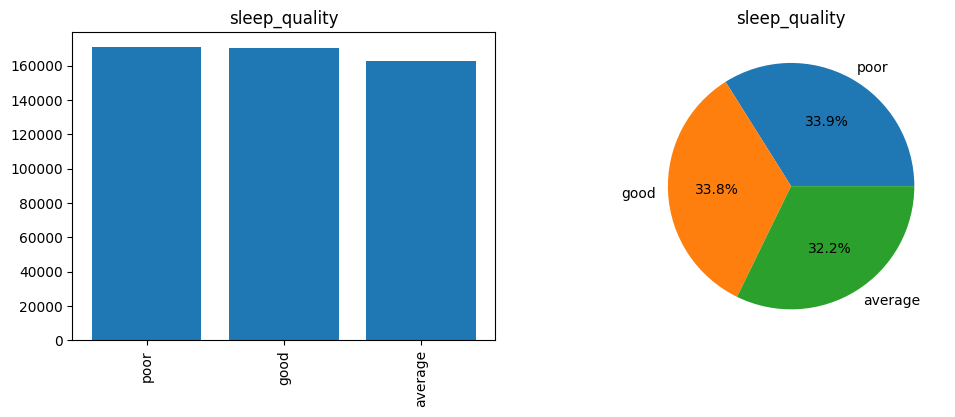

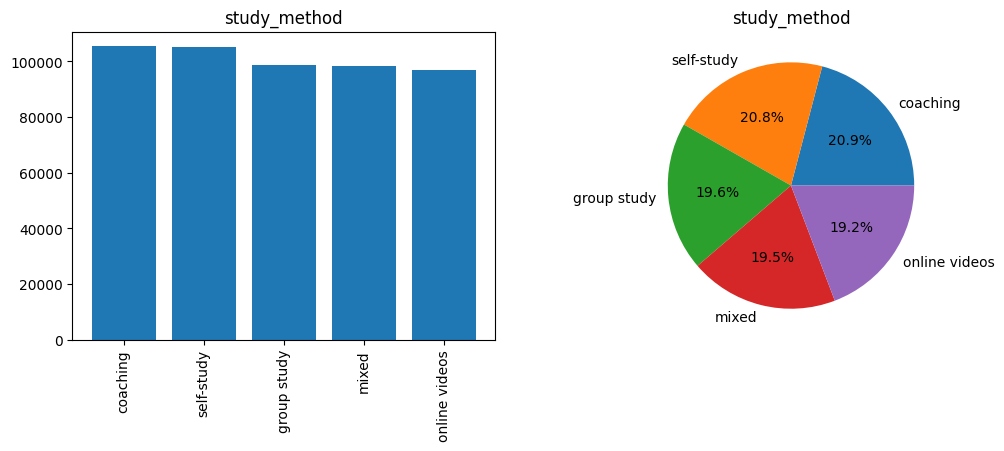

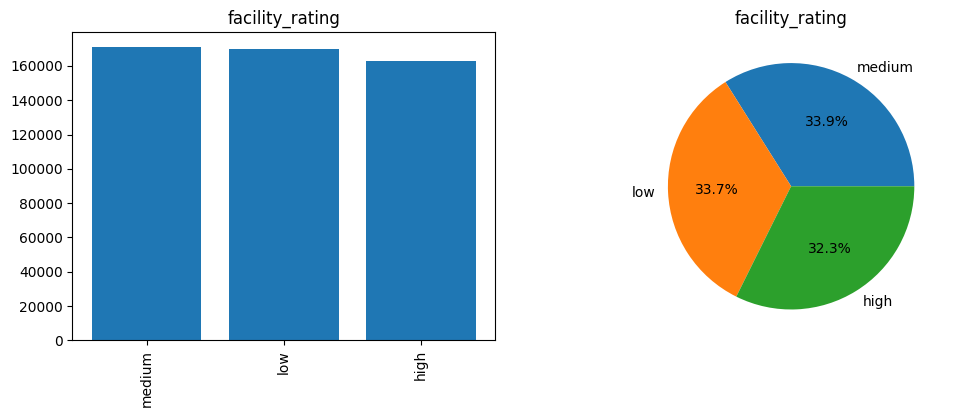

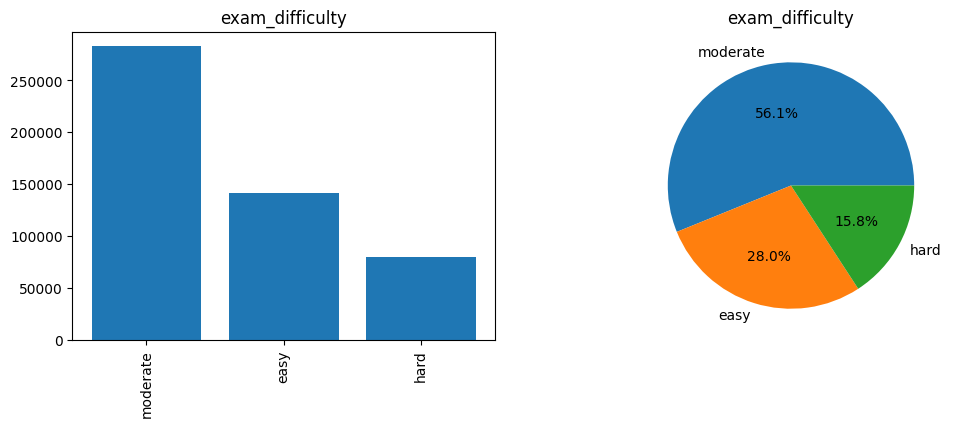

In [104]:
for col in cat_cols:
    counts = X_train[col].value_counts()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].bar(counts.index.astype(str), counts.values)
    ax[0].set_title(col)
    ax[0].tick_params(axis="x", rotation=90)

    ax[1].pie(counts.values, labels=counts.index.astype(str), autopct='%1.1f%%')
    ax[1].set_title(col)

    plt.show()

единственное, что сильно выбивается - наличие интернета у людей, но его мы оставим

еще чуть-чуть обработки данных: категориальные через one-hot

In [105]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_features = encoder.fit_transform(X_train[cat_cols])

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_train.index
)

data_ohe_train = pd.concat(
    [X_train[num_cols], encoded_df],
    axis=1
)

data_ohe_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504000 entries, 625149 to 121958
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         504000 non-null  int64  
 1   study_hours                 504000 non-null  float64
 2   class_attendance            504000 non-null  float64
 3   sleep_hours                 504000 non-null  float64
 4   gender_male                 504000 non-null  float64
 5   gender_other                504000 non-null  float64
 6   course_b.sc                 504000 non-null  float64
 7   course_b.tech               504000 non-null  float64
 8   course_ba                   504000 non-null  float64
 9   course_bba                  504000 non-null  float64
 10  course_bca                  504000 non-null  float64
 11  course_diploma              504000 non-null  float64
 12  internet_access_yes         504000 non-null  float64
 13  sleep_quality_

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 504000 entries, 625149 to 121958
Series name: exam_score
Non-Null Count   Dtype  
--------------   -----  
504000 non-null  float64
dtypes: float64(1)
memory usage: 7.7 MB


In [107]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [108]:
model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.5,
    tree_method="hist",
    random_state=42
)

model.fit(data_ohe_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [109]:
encoded_features_test = encoder.transform(X_test[cat_cols])

encoded_df_test = pd.DataFrame(
    encoded_features_test,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_test.index
)

data_ohe_test = pd.concat([X_test[num_cols], encoded_df_test], axis=1)

preds = model.predict(data_ohe_test)

r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"R2 Score: {r2:.4f}")
print(f"Средняя ошибка (MAE): {mae:.2f} балла")

R2 Score: 0.7838
Средняя ошибка (MAE): 7.00 балла


получили адекватные значения метрик, можно открывать тестовые данные. их обрабатываем так же, как тестовые (ohe)

In [110]:
data_send = pd.read_csv('test.csv')

enc_f_send = encoder.transform(data_send[cat_cols])

enc_df_send = pd.DataFrame(
    enc_f_send,
    columns=encoder.get_feature_names_out(cat_cols),
    index=data_send.index
)

data_ohe_send = pd.concat([data_send[num_cols], enc_df_send], axis=1)

ans = model.predict(data_ohe_send)

In [112]:
subm = pd.read_csv('sample_submission.csv')
subm.head()

,id,exam_score
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0


In [113]:
subm['exam_score'] = ans

subm.to_csv('my_subm.csv', index=None)

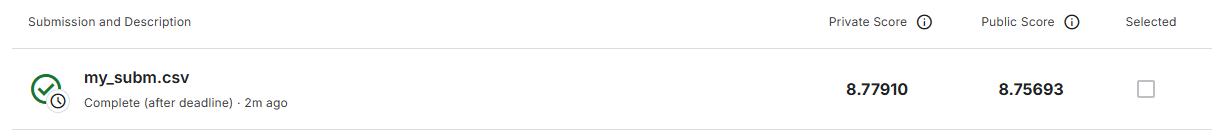

In [114]:
from IPython.display import Image
Image('/content/sc.png')

***результат:)***